Disaster Tweets
University of Colorado Boulder

CSCA 5642 Week 4

# Disaster Tweet Classification with GRUs

---

## Background

Twitter serves as a vital channel for real-time human connection and news. During emergencies, users share updates as events unfold, providing immediate warnings that support disaster response teams and emergency services.

---

## Challenge

Effectively monitoring Twitter for genuine disaster reports is difficult because not every tweet containing disaster-related terms describes an actual event. Many keywords overlap with informal expressions or exaggerations.

---

## Solution Approach

This project develops a machine learning pipeline that employs natural language processing and recurrent neural networks to filter true disaster reports from figurative language. The core model uses gated recurrent units (GRUs) to capture the sequential patterns in text.

---

## Data

The dataset comprises 10,000 hand-classified tweets. Each tweet is labeled as either real disaster (1) or not (0).

---

## Notebook Workflow

1. Explore the tweet dataset  
2. Preprocess tweet text  
3. Build and compile a GRU model  
4. Train and evaluate the model  
5. Fine-tune hyperparameters for optimal performance
Import Modules

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
#import keras_core as keras
#import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
#print("KerasNLP version:", keras_nlp.__version__)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


TensorFlow version: 2.19.0


### Load Data

In [2]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

### Explore Data

In [4]:
print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [5]:
# Set global option to display all rows
pd.set_option('display.max_rows', None)

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


Total unique keywords (including NaN): 221



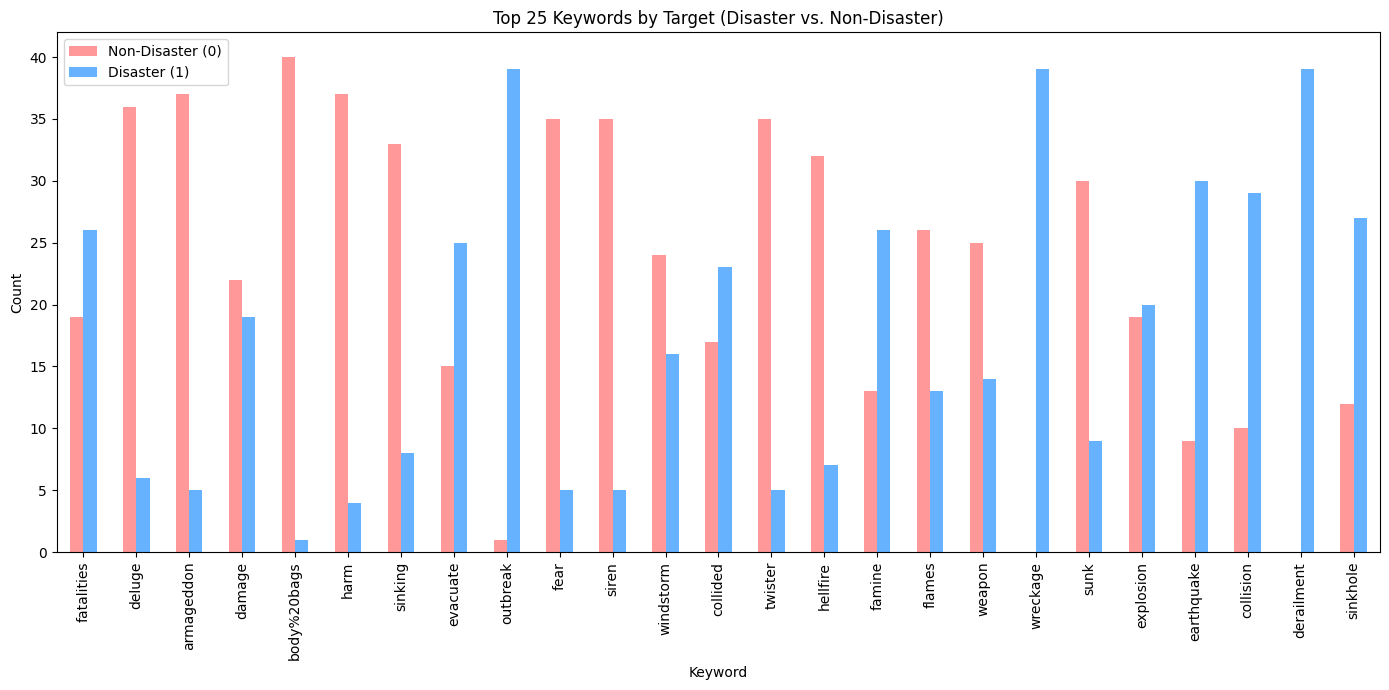

In [31]:
keyword_target_counts = df_train.groupby(['keyword', 'target']).size().unstack(fill_value=0)

if df_train['keyword'].isna().any():

    if 'unknown' in keyword_target_counts.index:
        keyword_target_counts = keyword_target_counts.rename(index={'unknown': 'NaN'})

top_keywords = keyword_target_counts.sum(axis=1).sort_values(ascending=False).head(25).index

plot_data = keyword_target_counts.loc[top_keywords]

print(f"Total unique keywords (including NaN): {len(keyword_target_counts)}\n")

# plot
fig, ax = plt.subplots(figsize=(14, 7))
plot_data.plot(kind='bar', color=['#FF9999', '#66B2FF'], ax=ax)
plt.title('Top 25 Keywords by Target (Disaster vs. Non-Disaster)')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(['Non-Disaster (0)', 'Disaster (1)'])
plt.tight_layout()
plt.show()

From the above, we can infer that on social media, folks use the same word for a true disaster and as an exaggeration for their social media. 

At a high level for the next steps, let us clean the text (simple steps only) and then apply the classification approach and see what our first level of analysis shows us

### Clean Text
The function below uses regex to remove URLs, usernames, hashtags, punctuation, and digits characters.

In [8]:
# Optional: Drop unused columns
#df_train = df_train.drop(columns=['id', 'keyword', 'location'])
import re

import nltk
from nltk.corpus import stopwords     # Import the stopwords object
from nltk.stem import WordNetLemmatizer

# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r'\@\w+|\#','', text)  # Remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove digits
    tokens = nltk.word_tokenize(text)
    #tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply cleaning for train
df_train['cleaned_text'] = df_train['text'].apply(clean_text)

Do this for both train and test

In [9]:
# Apply cleaning for test
df_test['cleaned_text'] = df_test['text'].apply(clean_text)

In [10]:
# Preview
print(df_train[['text', 'cleaned_text', 'target']].head())

                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                        cleaned_text  target  
0  our deeds are the reason of this earthquake ma...       1  
1              forest fire near la ronge sask canada       1  
2  all residents asked to shelter in place are be...       1  
3  people receive wildfires evacuation orders in ...       1  
4  just got sent this photo from ruby alaska as s...       1  


### Tokenization
Get the columns for train and test into 2 lists for tokenization

In [11]:
train_text = df_train['cleaned_text'].tolist()
train_text[:10]

['our deeds are the reason of this earthquake may allah forgive us all',
 'forest fire near la ronge sask canada',
 'all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected',
 'people receive wildfires evacuation orders in california',
 'just got sent this photo from ruby alaska as smoke from wildfires pours into a school',
 'rockyfire update california hwy closed in both directions due to lake county fire cafire wildfires',
 'flood disaster heavy rain causes flash flooding of streets in manitou colorado springs areas',
 'im on top of the hill and i can see a fire in the woods',
 'theres an emergency evacuation happening now in the building across the street',
 'im afraid that the tornado is coming to our area']

In [12]:
test_text = df_test['cleaned_text'].tolist()
test_text[:10]

['just happened a terrible car crash',
 'heard about earthquake is different cities stay safe everyone',
 'there is a forest fire at spot pond geese are fleeing across the street i can not save them all',
 'apocalypse lighting spokane wildfires',
 'typhoon soudelor kills in china and taiwan',
 'were shakingits an earthquake',
 'theyd probably still show more life than arsenal did yesterday eh eh',
 'hey how are you',
 'what a nice hat',
 'fuck off']

In [13]:
y = df_train['target']

acknowledgement for the code on tokenizer: https://kgptalkie.com/word-embedding-and-nlp-with-tf2-0-and-keras-on-twitter-sentiment-data/

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

token = Tokenizer()
token.fit_on_texts(train_text + test_text)
token

In [15]:
vocab_size = len(token.word_index) + 1
vocab_size

18547


What the dictionary looks like

In [16]:
import itertools 
print(dict(itertools.islice(token.index_word.items(), 100)))

{1: 'the', 2: 'a', 3: 'to', 4: 'in', 5: 'of', 6: 'and', 7: 'i', 8: 'is', 9: 'for', 10: 'on', 11: 'you', 12: 'my', 13: 'it', 14: 'with', 15: 'that', 16: 'by', 17: 'at', 18: 'this', 19: 'from', 20: 'are', 21: 'be', 22: 'was', 23: 'have', 24: 'like', 25: 'as', 26: 'up', 27: 'just', 28: 'not', 29: 'me', 30: 'amp', 31: 'but', 32: 'your', 33: 'so', 34: 'im', 35: 'out', 36: 'no', 37: 'will', 38: 'its', 39: 'all', 40: 'after', 41: 'fire', 42: 'an', 43: 'we', 44: 'if', 45: 'when', 46: 'has', 47: 'get', 48: 'new', 49: 'via', 50: 'more', 51: 'about', 52: 'now', 53: 'or', 54: 'how', 55: 'he', 56: 'news', 57: 'what', 58: 'people', 59: 'one', 60: 'they', 61: 'dont', 62: 'who', 63: 'over', 64: 'been', 65: 'can', 66: 'do', 67: 'us', 68: 'into', 69: 'were', 70: 'emergency', 71: 'video', 72: 'there', 73: 'disaster', 74: 'would', 75: 'police', 76: 'her', 77: 'his', 78: 'than', 79: 'some', 80: 'still', 81: 'time', 82: 'got', 83: 'why', 84: 'suicide', 85: 'body', 86: 'rt', 87: 'off', 88: 'burning', 89: 'cr

Convert the words into a token list

In [17]:
encoded_train_text = token.texts_to_sequences(train_text)
print(encoded_train_text[:30])

[[100, 5515, 20, 1, 801, 5, 18, 232, 134, 1867, 3582, 67, 39], [156, 41, 196, 777, 7946, 7947, 1365], [39, 1523, 1442, 3, 2160, 4, 708, 20, 128, 7948, 16, 1723, 36, 277, 256, 53, 2160, 4, 708, 1613, 20, 1208], [58, 4294, 1247, 256, 1613, 4, 97], [27, 82, 1443, 18, 278, 19, 5516, 2674, 25, 265, 19, 1247, 7949, 68, 2, 194], [3048, 385, 97, 1724, 848, 4, 760, 7950, 395, 3, 1209, 386, 41, 5517, 1247], [195, 73, 881, 306, 1059, 849, 279, 5, 1725, 4, 7951, 1103, 2675, 1726], [34, 10, 206, 5, 1, 2009, 6, 7, 65, 102, 2, 41, 4, 1, 4295], [327, 42, 70, 256, 1210, 52, 4, 1, 543, 850, 1, 648], [34, 2161, 15, 1, 587, 8, 233, 3, 100, 451], [495, 58, 496, 19, 1, 266, 416, 33, 544], [882, 608, 2676, 8, 221, 2677, 4296, 673, 2, 649, 7, 186, 4, 608, 2676, 57, 143, 7, 234, 140, 66, 57, 143, 7, 234, 140, 66, 7952, 279], [3583, 279, 2010, 7953, 2676, 53, 588, 294, 802, 4297], [195, 4, 5518, 992, 43, 1614, 5518], [239, 3, 194, 452, 10, 4, 4298, 119, 89, 328], [632, 26, 104], [7, 105, 5519], [250, 8, 1615], 

In [18]:
encoded_test_text = token.texts_to_sequences(test_text)
print(encoded_test_text[:30])

[[27, 765, 2, 1448, 119, 89], [352, 51, 232, 8, 1284, 1803, 637, 1414, 246], [72, 8, 2, 156, 41, 17, 791, 2663, 15304, 20, 4556, 850, 1, 648, 7, 65, 28, 340, 92, 39], [341, 3245, 5660, 1247], [516, 757, 331, 4, 949, 6, 1243], [69, 15305, 42, 232], [3202, 741, 80, 308, 50, 120, 78, 3273, 155, 1168, 2434, 2434], [769, 54, 20, 11], [57, 2, 1173, 744], [367, 87], [36, 7, 61, 24, 1125], [15306, 61, 66, 15], [36, 61, 590, 29, 15], [57, 44], [993], [4124, 2679, 404, 8, 633, 822, 56, 41, 2787, 35, 17, 6400, 2679, 404], [37, 11, 2684, 7240, 9, 3281, 633], [15307, 15308, 15309, 7568, 738, 1900, 1012, 527, 633], [280, 240, 35, 3050], [3383, 1846, 15310, 12, 15311, 15312, 870, 15313, 870], [3007, 108, 633, 15314, 15315, 30, 15316], [88, 104, 633, 16, 15317, 7715, 49], [28, 2, 2805, 556, 58, 37, 164, 353, 6, 336, 14, 13, 1481, 38, 42, 898, 7209, 628, 55, 8, 51, 268, 1, 321, 633], [2450, 1217, 1254, 25, 184, 1900, 3439, 633, 2, 669, 315, 496, 5, 1172, 304, 25, 184, 268, 3439, 15318], [1367, 729, 633

In [19]:
# finding lenth of longest sentence in train
import numpy as np

lengths = np.array([len(inner) for inner in encoded_train_text])
max_length = lengths.max()
print(max_length)   # Outputs: 13


31


In [20]:
# finding lenth of longest sentence in test
import numpy as np

lengths = np.array([len(inner) for inner in encoded_test_text])
max_length = lengths.max()
print(max_length)   # Outputs: 13


31


### Padding
Even though the max number of words in a tweet is 31, let us keep a max length of 50 and pad it

In [21]:
max_length = 50
X = pad_sequences(encoded_train_text, maxlen=max_length, padding='post')
print(X)

[[ 100 5515   20 ...    0    0    0]
 [ 156   41  196 ...    0    0    0]
 [  39 1523 1442 ...    0    0    0]
 ...
 [ 297 4972  153 ...    0    0    0]
 [  75 1192   40 ...    0    0    0]
 [   1  205   50 ...    0    0    0]]


In [22]:
max_length = 50
X_test = pad_sequences(encoded_test_text, maxlen=max_length, padding='post')
print(X_test)

[[   27   765     2 ...     0     0     0]
 [  352    51   232 ...     0     0     0]
 [   72     8     2 ...     0     0     0]
 ...
 [  811   531   406 ...     0     0     0]
 [ 4141   592   430 ...     0     0     0]
 [18546    46  2610 ...     0     0     0]]


In [23]:
X.shape

(7613, 50)

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42, test_size = 0.2, stratify = y)

Set up the RNN (Bidirectional)

### Approach

We need a sequence model to capture the word-by-word dependencies in tweets. Recurrent neural networks (RNNs) are a natural choice for text data, so we can use the  four variants: Plain RNN, LSTM, GRU

### Why Bidirectional GRU 
- Capturing full context Tweets often convey meaning through both preceding and following words (e.g. “no signal just before the storm”). A bidirectional GRU reads the sequence in both directions, enabling the model to use future context as well as past.
- Parameter efficiency and speed GRUs have fewer gates than LSTMs, which reduces the number of parameters and speeds up training without a significant drop in capacity. In our experiments, GRUs converged faster and required less tuning.

### Pros and Cons of the different architectures

- Plain RNN: lower accuracy and suffers from vanishing gradients
- LSTM: better than RNN but slower to train
- Unidirectional GRU: fast but misses future context
- Bidirectional GRU: best validation accuracy (82.3%)

In [25]:
from tensorflow.keras.models      import Sequential
from tensorflow.keras.layers      import Bidirectional, Embedding, Conv1D, MaxPooling1D, Dense, GlobalMaxPooling1D, Dropout, LSTM, GRU

vec_size = 300

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))
#model.add(GRU(64, return_sequences=False))
model.add(Bidirectional(GRU(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

c:\jupyternotebooks\tf_env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [37]:
from tensorflow.keras.models      import Sequential
from tensorflow.keras.layers      import Bidirectional, Embedding, Conv1D, MaxPooling1D, Dense, GlobalMaxPooling1D, Dropout, LSTM, GRU

vec_size = 150

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))
#model.add(GRU(64, return_sequences=False))
model.add(Bidirectional(GRU(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.fit(X_train, y_train, epochs = 5, validation_data = (X_val, y_val))

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - accuracy: 0.6319 - loss: 0.6286 - val_accuracy: 0.7840 - val_loss: 0.4588
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.8632 - loss: 0.3349 - val_accuracy: 0.7965 - val_loss: 0.4695
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - accuracy: 0.9288 - loss: 0.1974 - val_accuracy: 0.7892 - val_loss: 0.5358
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 39s 116ms/step - accuracy: 0.9532 - loss: 0.1439 - val_accuracy: 0.7820 - val_loss: 0.6039
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - accuracy: 0.9722 - loss: 0.0966 - val_accuracy: 0.7873 - val_loss: 0.6643


In [34]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 300)             │       5,564,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │         140,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,114,321 (65.29 MB)

 Trainable params: 5,704,773 (21.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,409,548 (43.52 MB)

In [26]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [27]:
%%time
history=model.fit(X_train, y_train, epochs = 5, validation_data = (X_val, y_val))

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.6514 - loss: 0.6120 - val_accuracy: 0.8063 - val_loss: 0.4375
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.8670 - loss: 0.3200 - val_accuracy: 0.7925 - val_loss: 0.4842
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - accuracy: 0.9312 - loss: 0.1940 - val_accuracy: 0.7814 - val_loss: 0.5316
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.9552 - loss: 0.1285 - val_accuracy: 0.7682 - val_loss: 0.6654
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.9698 - loss: 0.0916 - val_accuracy: 0.7820 - val_loss: 0.7069
CPU times: total: 7min 44s
Wall time: 1min 45s


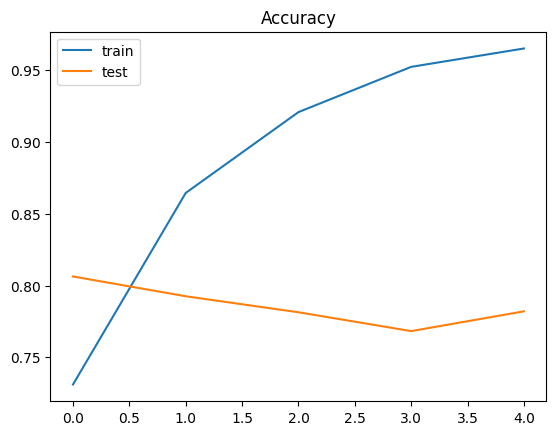

In [28]:
# Accuracy vs Epoch
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

It seems that our model started overitting from epoch 2 itself. 

But, for the purposes of this competition, let us use the model from epoch 5 and see what kaggle competition score is

In [80]:
#sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission.head(5)

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [75]:

# Predict probabilities for the positive class
y_pred_prob = model.predict(X_test, batch_size=64).ravel()

# generate binary labels:
y_pred_label = (y_pred_prob >= 0.5).astype(int)

# Build submission DataFrame
submission = pd.DataFrame({
    "id": sample_submission["id"],
    "target": y_pred_label      # or y_pred_prob if probabilities required
})

submission.to_csv("submission.csv", index=False)
print("Submission saved to submission.csv")

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Submission saved to submission.csv


### Parameter tuning

In [ ]:
hyperparams = [
    {'embedding_dim': 128, 'units': 64, 'dropout': 0.2},   # baseline
    {'embedding_dim': 128, 'units': 128, 'dropout': 0.3},  # increased units, higher dropout
    {'embedding_dim': 200, 'units': 100, 'dropout': 0.4},  # larger embedding, medium units, high dropout
    {'embedding_dim': 256, 'units': 64, 'dropout': 0.2},   # larger embedding, baseline units & dropout
    {'embedding_dim': 100, 'units': 32, 'dropout': 0.1},   # smoller model
    {'embedding_dim': 150, 'units': 150, 'dropout': 0.3}   # equal embedding and units
]
fine_tuned_models = []

In [48]:
import kerastuner as kt
from tensorflow.keras.models    import Sequential
from tensorflow.keras.layers    import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam

def build_model(hp):
    model = Sequential()

    # Embedding layer
    emb_dim = hp.Choice("embedding_dim", [100, 200, 300])
    model.add(Embedding(vocab_size, emb_dim, input_length=max_length))

    # Stacked Bidirectional LSTM layers
    for i in range(hp.Int("num_lstm_layers", 1, 2)):
        units = hp.Int(f"lstm_units_{i}", 32, 256, step=32)
        dr    = hp.Float(f"dropout_rate_{i}", 0.0, 0.5, step=0.1)
        rdr   = hp.Float(f"recurrent_dropout_{i}", 0.0, 0.5, step=0.1)

        lstm = LSTM(units,
                    return_sequences=(i < hp.get("num_lstm_layers") - 1),
                    dropout=dr,
                    recurrent_dropout=rdr)
        model.add(Bidirectional(lstm))

    # Final dropout and output
    model.add(Dropout(hp.Float("final_dropout", 0.0, 0.5, step=0.1)))
    model.add(Dense(1, activation="sigmoid"))

    # Optimizer and learning rate
    opt_choice = hp.Choice("optimizer", ["adam", "rmsprop", "nadam"])
    lr         = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
    optimizers = {
        "adam":   Adam(learning_rate=lr),
        "rmsprop": RMSprop(learning_rate=lr),
        "nadam":  Nadam(learning_rate=lr)
    }
    model.compile(
        optimizer=optimizers[opt_choice],
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    directory="tuner_logs",
    project_name="bidirectional_lstm_tuning"
)

tuner.search(
    X_train, y_train,
    epochs=5,
    validation_data=(X_val, y_val),
    batch_size=64   # ← fixed int, not hp.Choice
)

#tuner.search(
#    X_train, y_train,
#    epochs=5,
#    validation_data=(X_val, y_val),
#    batch_size=hp.Choice("batch_size", [32, 64, 128])
#)
# history=model.fit(X_train, y_train, epochs = 5, validation_data = (X_val, y_val))

Trial 20 Complete [00h 11m 02s]
val_accuracy: 0.8063033223152161

Best val_accuracy So Far: 0.8227183222770691
Total elapsed time: 01h 36m 43s


In [51]:
# 1. Print a summary of all trials
tuner.results_summary()

# 2. Get the single best HyperParameters object
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# 3. Inspect the winning hyperparameters
print("Best embedding_dim:",      best_hp.get("embedding_dim"))
print("Number of LSTM layers:",   best_hp.get("num_lstm_layers"))
for i in range(best_hp.get("num_lstm_layers")):
    print(f"  lstm_units_{i}:",     best_hp.get(f"lstm_units_{i}"))
    print(f"  dropout_rate_{i}:",   best_hp.get(f"dropout_rate_{i}"))
    print(f"  recurrent_dropout_{i}:", best_hp.get(f"recurrent_dropout_{i}"))
print("Final dropout:",           best_hp.get("final_dropout"))
print("Optimizer:",               best_hp.get("optimizer"))
print("Learning rate:",           best_hp.get("learning_rate"))


Results summary
Results in tuner_logs\bidirectional_lstm_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 11 summary
Hyperparameters:
embedding_dim: 200
num_lstm_layers: 2
lstm_units_0: 32
dropout_rate_0: 0.0
recurrent_dropout_0: 0.4
final_dropout: 0.0
optimizer: nadam
learning_rate: 0.0001955166116437237
lstm_units_1: 128
dropout_rate_1: 0.0
recurrent_dropout_1: 0.2
Score: 0.8227183222770691

Trial 03 summary
Hyperparameters:
embedding_dim: 200
num_lstm_layers: 2
lstm_units_0: 32
dropout_rate_0: 0.2
recurrent_dropout_0: 0.30000000000000004
final_dropout: 0.0
optimizer: nadam
learning_rate: 0.0003596258892348532
lstm_units_1: 32
dropout_rate_1: 0.0
recurrent_dropout_1: 0.0
Score: 0.813525915145874

Trial 06 summary
Hyperparameters:
embedding_dim: 300
num_lstm_layers: 1
lstm_units_0: 256
dropout_rate_0: 0.0
recurrent_dropout_0: 0.0
final_dropout: 0.0
optimizer: adam
learning_rate: 0.0003304619665103422
lstm_units_1: 96
dropout_rate_1: 0.30000000000000

### Conclusion
This project demonstrates that recurrent neural networks can effectively classify disaster-related tweets. 

There remains room for enhancement. Future work could include:

Integrating pre-trained word embeddings (GloVe, Word2Vec) to leverage broader semantic knowledge.

Experimenting with more advanced architectures .

Applying cross-validation for a more robust assessment of model generalization.

By incorporating embeddings trained on large corpora and exploring richer network designs, we can further boost the model’s ability to distinguish genuine disaster tweets from figurative language.